# Table of Contents

* [Chapter 1 : Import Packages](#chapter1)
* [Chapter 2 : Data Exploration](#chapter2)
    * [Section 2.1 : Reading Files](#subchapter2.1)
    * [Section 2.2 : Pre-Processing](#subchapter2.2)
    * [Section 2.3 : Analyzing Count of Accomodation Type, Chain Hotel & Star Rating](#subchapter2.3)
    * [Section 2.4 : Time Series Analysis](#subchapter2.4)
* [Chapter 3 : Data Visualization](#chapter3)
    * [Section 3.1 : Checkin Day Frequency](#subchapter3.1)
    * [Section 3.2 : Relationship Between Mean Normalized ADR USD and Days Prior](#subchapter3.2)
    * [Section 3.3 : Correlation Matrix](#subchapter3.3)
* [Chapter 4 : Numeric Prediction](#chapter4)
    * [Section 4.1 : Defining Evaluation Metrics](#subchapter4.1)
    * [Section 4.2 : Linear Regression](#subchapter4.2)
    * [Section 4.3 : Decision Tree Regressor](#subchapter4.3)
    * [Section 4.4 : Lasso Regression](#subchapter4.4)
    * [Section 4.5 : Ridge Regression](#subchapter4.5)
    * [Section 4.6 : Elastic Net Regression](#subchapter4.6)
* [Chapter 5 : Categorical Prediction](#chapter4)
    * [Section 5.1 : Defining Evaluation Metrics](#subchapter5.1)
    * [Section 5.2 : Logisitic Regression](#subchapter5.2)
    * [Section 5.3 : Decision Tree Classifier](#subchapter5.3)
    * [Section 5.4 : Random Forest Classifier](#subchapter5.4)
    * [Section 5.5 : Naive Bayes Classifier](#subchapter5.5)
    * [Section 5.6 : K-Nearest Neighbors](#subchapter5.6)
    * [Section 5.7 : Gradient Boost Classifier](#subchapter5.7)
    * [Section 5.8 : AdaBoost Classifier](#subchapter5.8)
    * [Section 5.9 : Neural Network](#subchapter5.9)

# Introduction

**Objective:**
The objective is to analyze historical booking data from five different cities, covering the period from 10/01/2016 to 12/31/2016. The analysis aims to understand how prices fluctuated as the booking date approached the check-in date and to identify potential business opportunities.

**Analysis Plan:**
1. **Data Exploration:** Begin by exploring the dataset to understand its structure and contents. Check for any missing or inconsistent data.
2. **Data Preprocessing:** Clean and preprocess the data as needed. This includes handling missing values, data transformations, and ensuring data consistency.
3. **Price Movement Analysis:** Investigate how prices evolved concerning the time gap between the booking and check-in dates. Visualize this trend using appropriate charts or graphs.
4. **Assumptions:** Document any assumptions made during the analysis and highlight their potential impact on the results.
5. **Factors Affecting Price:** Identify the key factors that influence price movement based on the dataset. Consider variables like location, seasonality, and booking lead time.
6. **Data Findings:** Present your analysis findings, including any trends or insights discovered regarding price changes over time.
7. **Conclusions:** Summarize the conclusions drawn from the data analysis and highlight any potential business opportunities or areas for improvement.

# 1. Import Packages <a class="anchor"  id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Data Exploration <a class="anchor"  id="chapter2"></a>

\# - No of record in each dataset\
ADR – Average Daily Rate in US Dollars (Customer Total Amount / Room Nights)\
Hotel ID – Property identification number\
City ID – City identification number\
Star rating – Property’s star rating\
Accommodation Type Name – Property’s accommodation type\
Chain Hotel – Indicates whether the property is part of a chain or not\
Booking date – Date of booking made\
Check-in date – Date of check-in\
Check-out date – Date of check-out

## 2.1 Reading the file <a class="anchor"  id="subchapter2.1"></a>

In [2]:
# Specify the file path of the Excel file
FILE = '/kaggle/input/hotel-booking/Hotel Price Analysis.xlsx'

# List of cities to process
CITIES = ['City_A', 'City_B', 'City_C', 'City_D', 'City_E']

# List to store individual hotel DataFrames
hotel_list = []

# Loop through each city
for CITY in CITIES:
    # Read the Excel sheet for the current city
    df = pd.read_excel(FILE, sheet_name=CITY)
    
    # Add a new column 'Table Name' to indicate the city
    df['City'] = CITY
    
    # Append the DataFrame to the list
    hotel_list.append(df)

# Concatenate all individual hotel DataFrames into a single DataFrame
hotel_df = pd.concat(hotel_list, ignore_index=True)

# Display the concatenated DataFrame
display(hotel_df)

,#,ADR_USD,hotel_id,city_id,star_rating,accommodation_type_name,chain_hotel,booking_date,checkin_date,checkout_date,City
0,1,71.060000,297388,9395,2.5,Hotel,non-chain,2016-08-02,2016-10-01,2016-10-02,City_A
1,2,76.560000,298322,9395,3.0,Hotel,non-chain,2016-08-02,2016-10-01,2016-10-02,City_A
2,3,153.880000,2313076,9395,5.0,Hotel,chain,2016-08-02,2016-10-01,2016-10-02,City_A
3,4,126.600000,2240838,9395,3.5,Hotel,non-chain,2016-08-04,2016-10-02,2016-10-03,City_A
4,5,115.080000,2240838,9395,3.5,Hotel,non-chain,2016-08-04,2016-10-02,2016-10-03,City_A
...,...,...,...,...,...,...,...,...,...,...,...
49059,4813,72.580000,130890,8584,4.0,Hotel,non-chain,2016-12-31,2016-12-31,2017-01-02,City_E
49060,4814,70.020000,130890,8584,4.0,Hotel,non-chain,2016-12-31,2016-12-31,2017-01-01,City_E
49061,4815,921.260000,21720,8584,5.0,Resort,non-chain,2016-12-31,2016-12-31,2017-01-01,City_E
49062,4816,345.086667,21720,8584,5.0,Resort,non-chain,2016-12-31,2016-12-31,2017-01-03,City_E


## 2.2 Preprocessing <a class="anchor"  id="subchapter2.2"></a>

In [3]:
# Define a function to calculate the number of days prior to check-in date
def calculate_days_prior(booking_date, checkin_date):
    days_prior = (checkin_date - booking_date).days
    return days_prior

# Define functions to get the day of the week for booking and check-in dates
def get_booking_day(booking_date):
    return booking_date.day_name()

def get_checkin_day(checkin_date):
    return checkin_date.day_name()

def get_booking_day_of_year(booking_date):
    return booking_date.day_of_year

def get_checkin_day_of_year(checkin_date):
    return checkin_date.day_of_year

def get_slope(hotel_id_slope, hotel_id):
    if hotel_id in hotel_id_slope:
        return hotel_id_slope.get(hotel_id)
    else: 
        hotel_id_df = hotel_df[hotel_df['hotel_id'] == hotel_id]
        try : 
            # Calculate the slope and intercept for the regression line
            slope, intercept = np.polyfit(hotel_id_df['days_prior'], hotel_id_df['normalized_price'], 1)
            sign = 'decreasing' if slope > 0 else 'increasing' 
            hotel_id_slope[hotel_id] = sign
            return sign
        except Exception as e :
            hotel_id_slope[hotel_id] = np.nan
            return np.nan

# Constant for the number of top records to consider
TOP = 5

hotel_id_slope = {}

# Calculate days prior and get booking/check-in days
hotel_df['days_prior'] = hotel_df.apply(lambda x: calculate_days_prior(x['booking_date'], x['checkin_date']), axis=1)
hotel_df['booking_day'] = hotel_df.apply(lambda x: get_booking_day(x['booking_date']), axis=1)
hotel_df['checkin_day'] = hotel_df.apply(lambda x: get_checkin_day(x['checkin_date']), axis=1)
hotel_df['booking_day_of_year'] = hotel_df.apply(lambda x: get_booking_day_of_year(x['booking_date']), axis=1)
hotel_df['checkin_day_of_year'] = hotel_df.apply(lambda x: get_checkin_day_of_year(x['checkin_date']), axis=1)

min_max_scaler = MinMaxScaler()

# Calculate the min max normalized ADR_USD for each accomodation tyoe name, star rating and city
hotel_df['normalized_price'] = hotel_df.groupby(['hotel_id', 'accommodation_type_name', 'City', 'star_rating', 'chain_hotel'])['ADR_USD'].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
hotel_df['price'] = hotel_df['hotel_id'].apply(lambda x : get_slope(hotel_id_slope, x))
hotel_df.dropna(inplace=True)
display(hotel_df[hotel_df['price'].isna()])

# Save the concatenated DataFrame to an Excel file
hotel_df.to_excel('Hotel Analysis.xlsx', index=False)

,#,ADR_USD,hotel_id,city_id,star_rating,accommodation_type_name,chain_hotel,booking_date,checkin_date,checkout_date,City,days_prior,booking_day,checkin_day,booking_day_of_year,checkin_day_of_year,normalized_price,price


* Introduce a new variable ***days_prior*** to calculate how many days advance was the booking made before checkin. Checkin_date - Booking_date.
* Introduce a new variable ***booking_day*** to understand what day of the week was the booking made. 
* Introduce a new variable ***checkin_day*** to understand what day of the week will the user check in.
* Introduce a new variable ***booking_day_of_year*** to understand what day of year was the booking made.
* Introduce a new variable ***checkin_day_of_year*** to understand what day of year will the user checkin.
* Introduce a new variable ***price*** to understand if the price of hotel is increasing or decreasing when booking date is nearer to check in date.

* Min Max Normalize the price across all hotel_id to have a fair comparison 

In [4]:
CATEGORICAL_COLS = ['accommodation_type_name', 'chain_hotel', 'checkin_day', 'price']
NUMERICAL_COLS = ['star_rating', 'days_prior', 'ADR_USD', 'normalized_price']

## 2.3 County of Accomodation Type, Chain Hotel, Star Rating <a class="anchor"  id="subchapter2.3"></a>

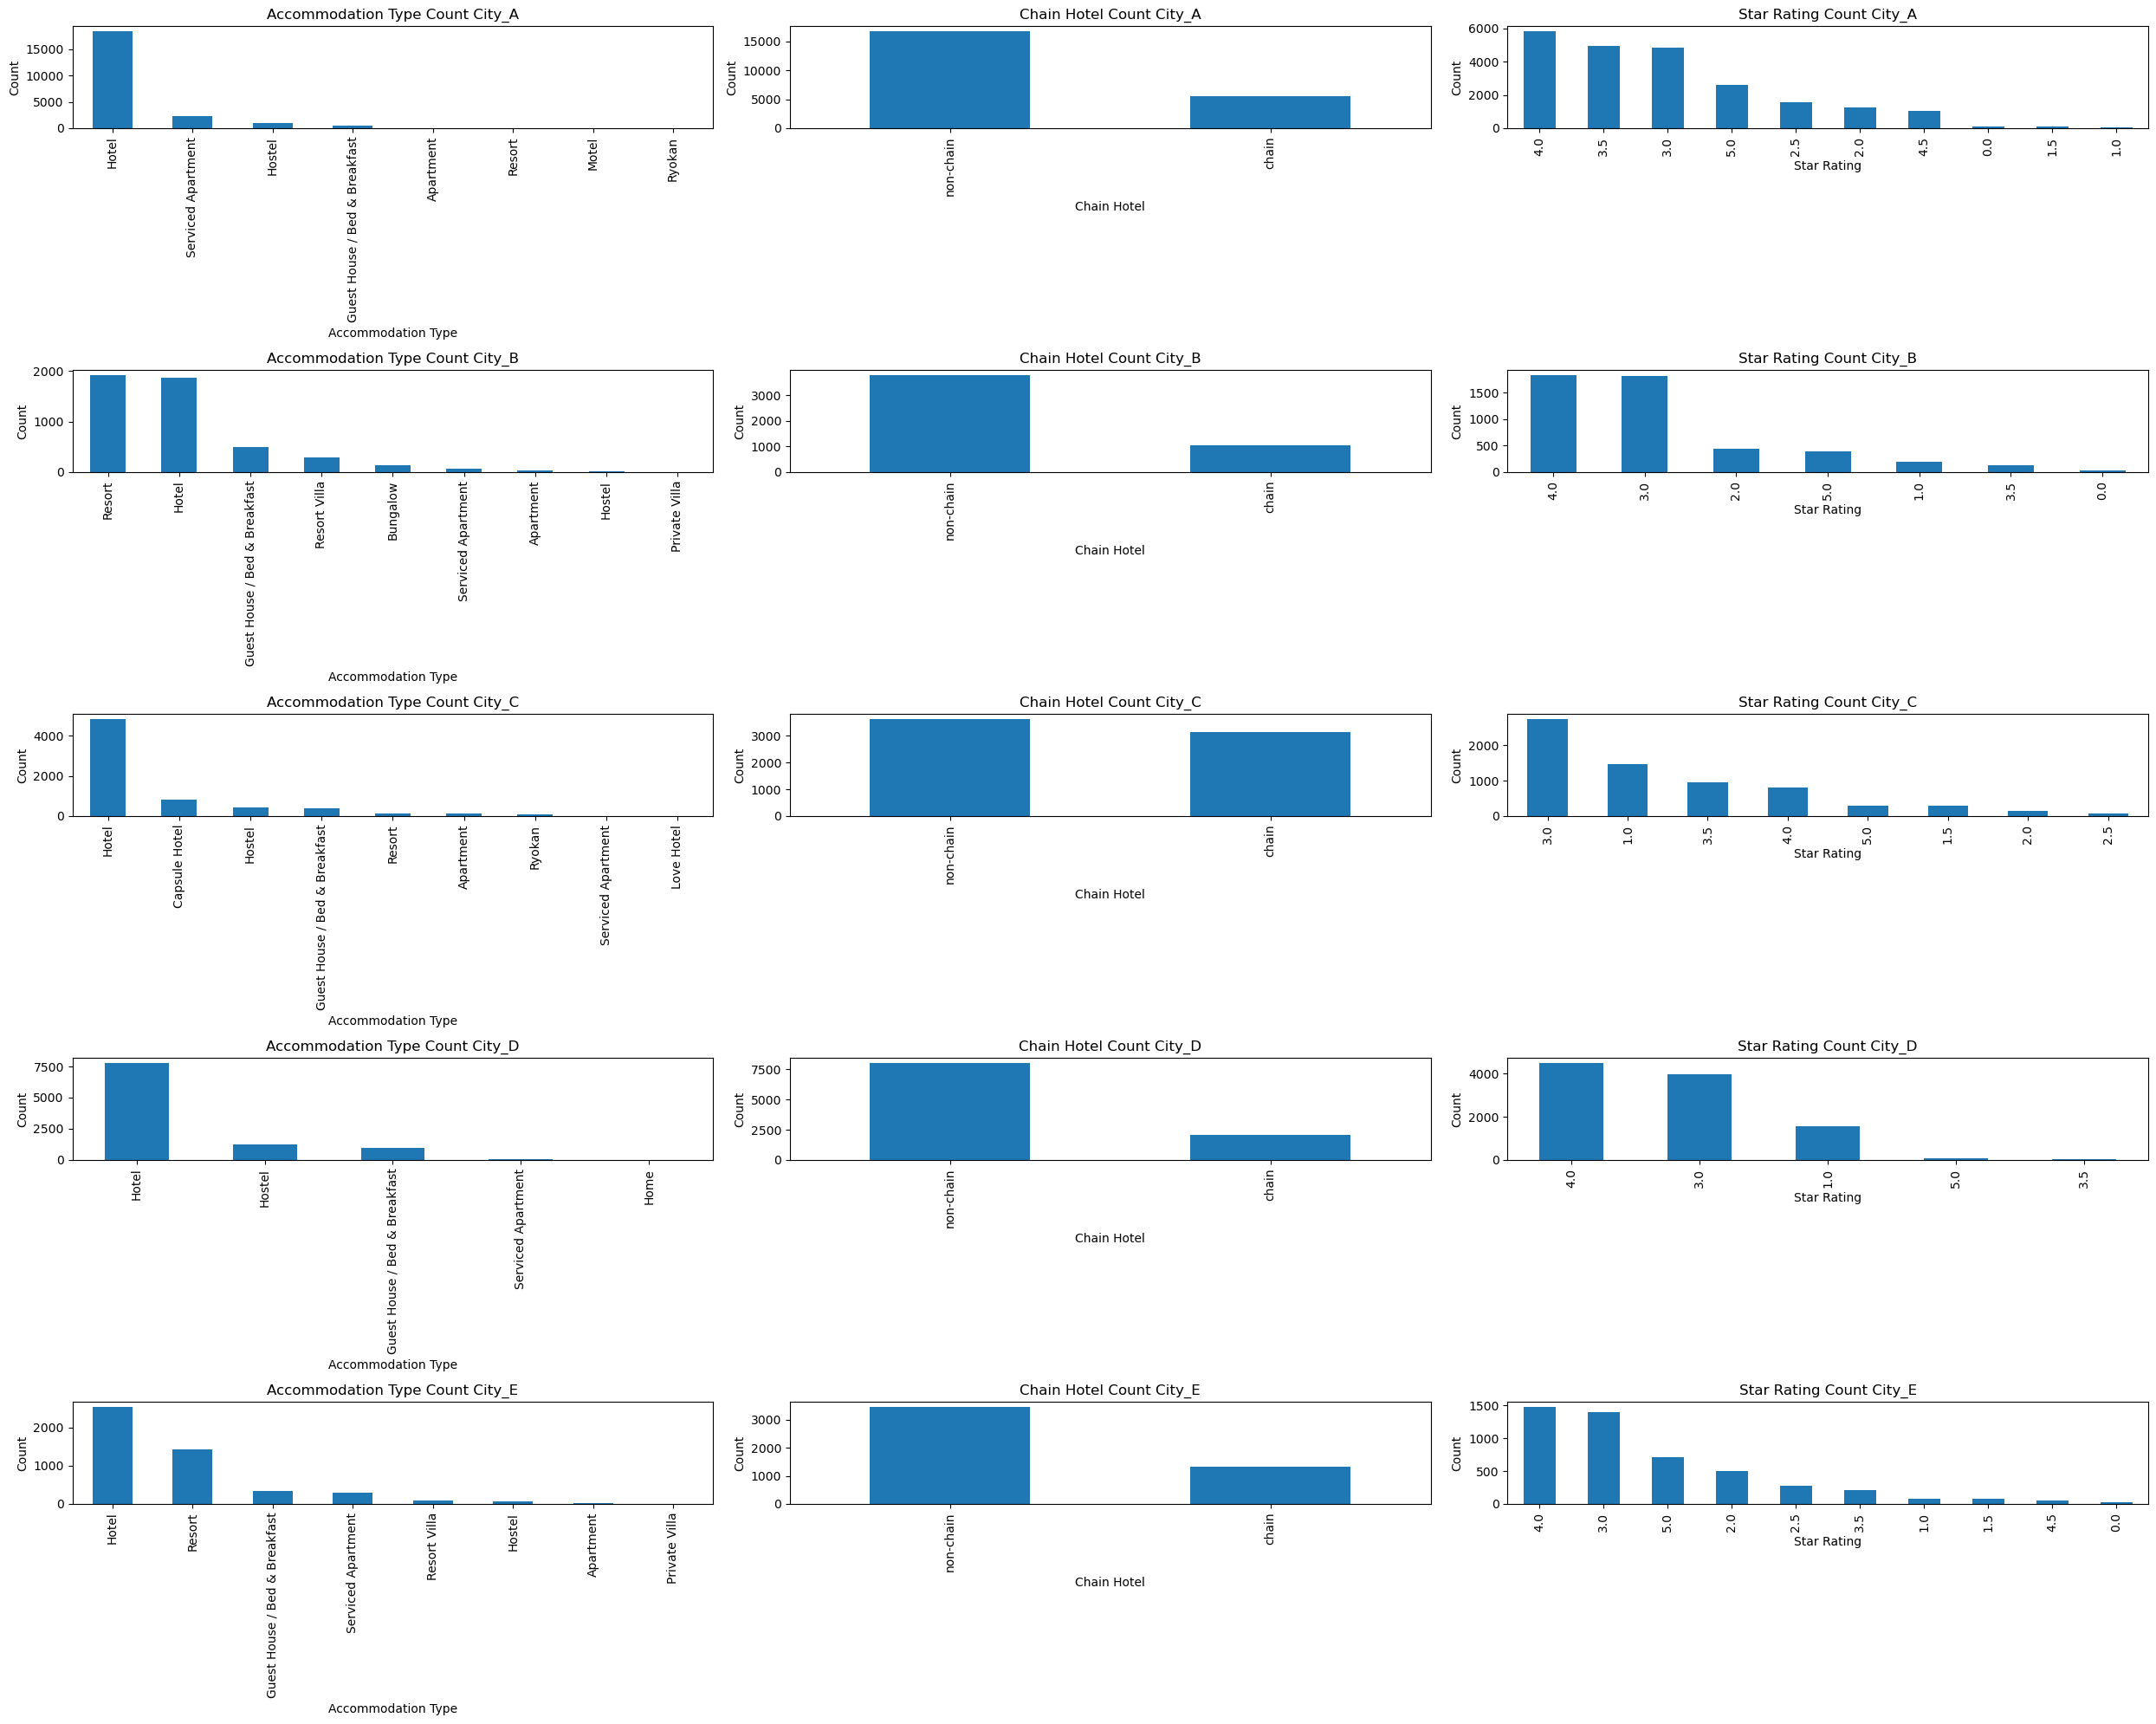

In [5]:
# Creating a subplot with 5 rows and 3 cols
fig, axes = plt.subplots(5, 3, figsize=(25, 20))

for idx, CITY in enumerate(CITIES):    
    col_idx = idx // 5  # Calculate the row index for the subplot
    row_idx = idx % 5   # Calculate the column index for the subplot
    ax = axes[row_idx, col_idx]
    
    # Plot 1: Accommodation Type Count
    accommodation_counts = hotel_df[hotel_df['City'] == CITY]['accommodation_type_name'].value_counts()
    accommodation_counts.plot(kind='bar', ax=ax)
    ax.set_title(f'Accommodation Type Count {CITY}')
    ax.set_xlabel('Accommodation Type')
    ax.set_ylabel('Count')

    ax1 = axes[row_idx, col_idx+1]
    # Plot 2 : Chain Hotel Count
    chain_counts = hotel_df[hotel_df['City'] == CITY]['chain_hotel'].value_counts()
    chain_counts.plot(kind='bar', ax=ax1)
    ax1.set_title(f'Chain Hotel Count {CITY}')
    ax1.set_xlabel('Chain Hotel')
    ax1.set_ylabel('Count')
    
    ax2 = axes[row_idx, col_idx+2]
    # Plot 3 : Star Rating Count
    star_counts = hotel_df[hotel_df['City'] == CITY]['star_rating'].value_counts()
    star_counts.plot(kind='bar', ax=ax2)
    ax2.set_title(f'Star Rating Count {CITY}')
    ax2.set_xlabel('Star Rating')
    ax2.set_ylabel('Count')    
 
plt.tight_layout()
plt.show()

1. In City A:
   - The predominant accommodation type is hotels.
   - Most of these hotels are non-chain establishments.
   - The majority of hotels in City A have star ratings of 4.0, 3.5, and 3.0.

2. In City B:
   - The primary accommodation types in City B are resorts and hotels.
   - The majority of hotels in City B are non-chain properties.
   - Star ratings of 4.0 and 3.0 are the most common among hotels in City B. <br>

3. Within City C:
   - The prevailing accommodation type is hotels.
   - The majority of these hotels are non-chain establishments.
   - Most hotels in City C have a star rating of 3.0.

4. In City D:
   - The primary accommodation type in City D is hotels.
   - Most of these hotels are non-chain establishments.
   - The most common star ratings among hotels in City D are 4.0 and 3.0. 

5. In City E:
   - City E is primarily characterized by hotels.
   - Most of the hotels in City E are non-chain properties.
   - The prevalent star ratings for hotels in City E are 4.0 and 3.0.

## 2.4 Time Series Analysis <a class="anchor"  id="subchapter2.4"></a>

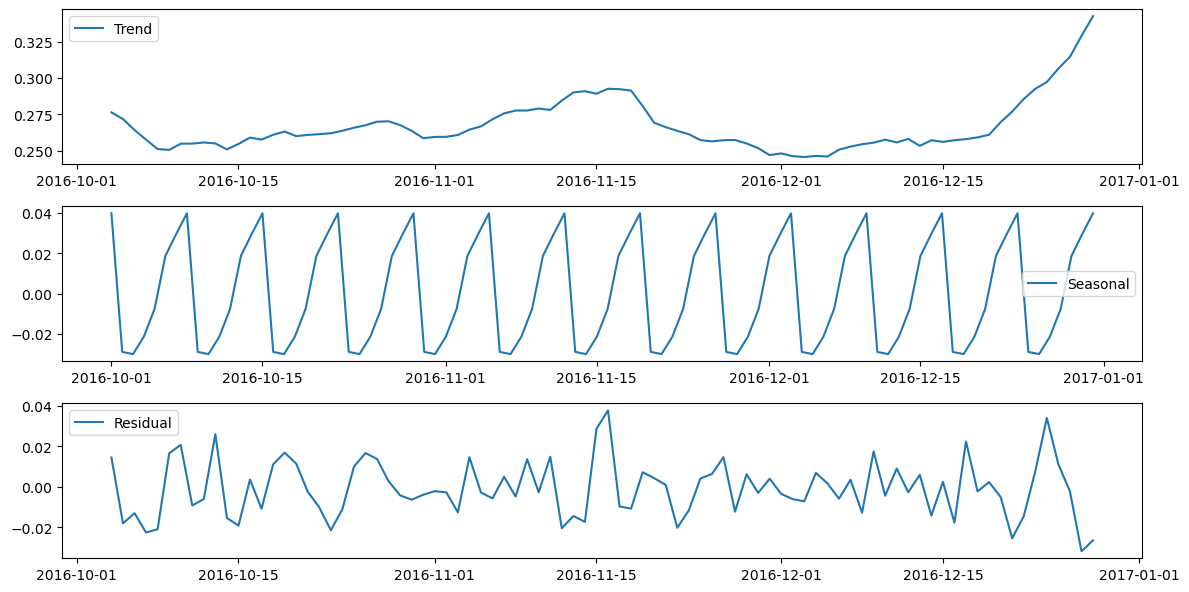

In [6]:
# Set the date column as the index
merged_checkin_date_df = hotel_df.groupby('checkin_date')['normalized_price'].mean()
merged_checkin_date_df = merged_checkin_date_df.asfreq('D')

# Perform time series analysis
decomposition = sm.tsa.seasonal_decompose(merged_checkin_date_df, model='additive')

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

* **Trend Observation:** There is a consistent upward trend observed from October to December. Towards the latter part of December, there is a substantial and noticeable surge in the trend.
* **Seasonal Patterns:** Throughout the months of October to December, specific days consistently exhibit spikes in activity, indicating a seasonal pattern.
* **Residual Analysis:** By removing the seasonal components from the trend, we are left with the residual data. It is evident that there are three significant spikes in activity within the residual data throughout the October to December period.

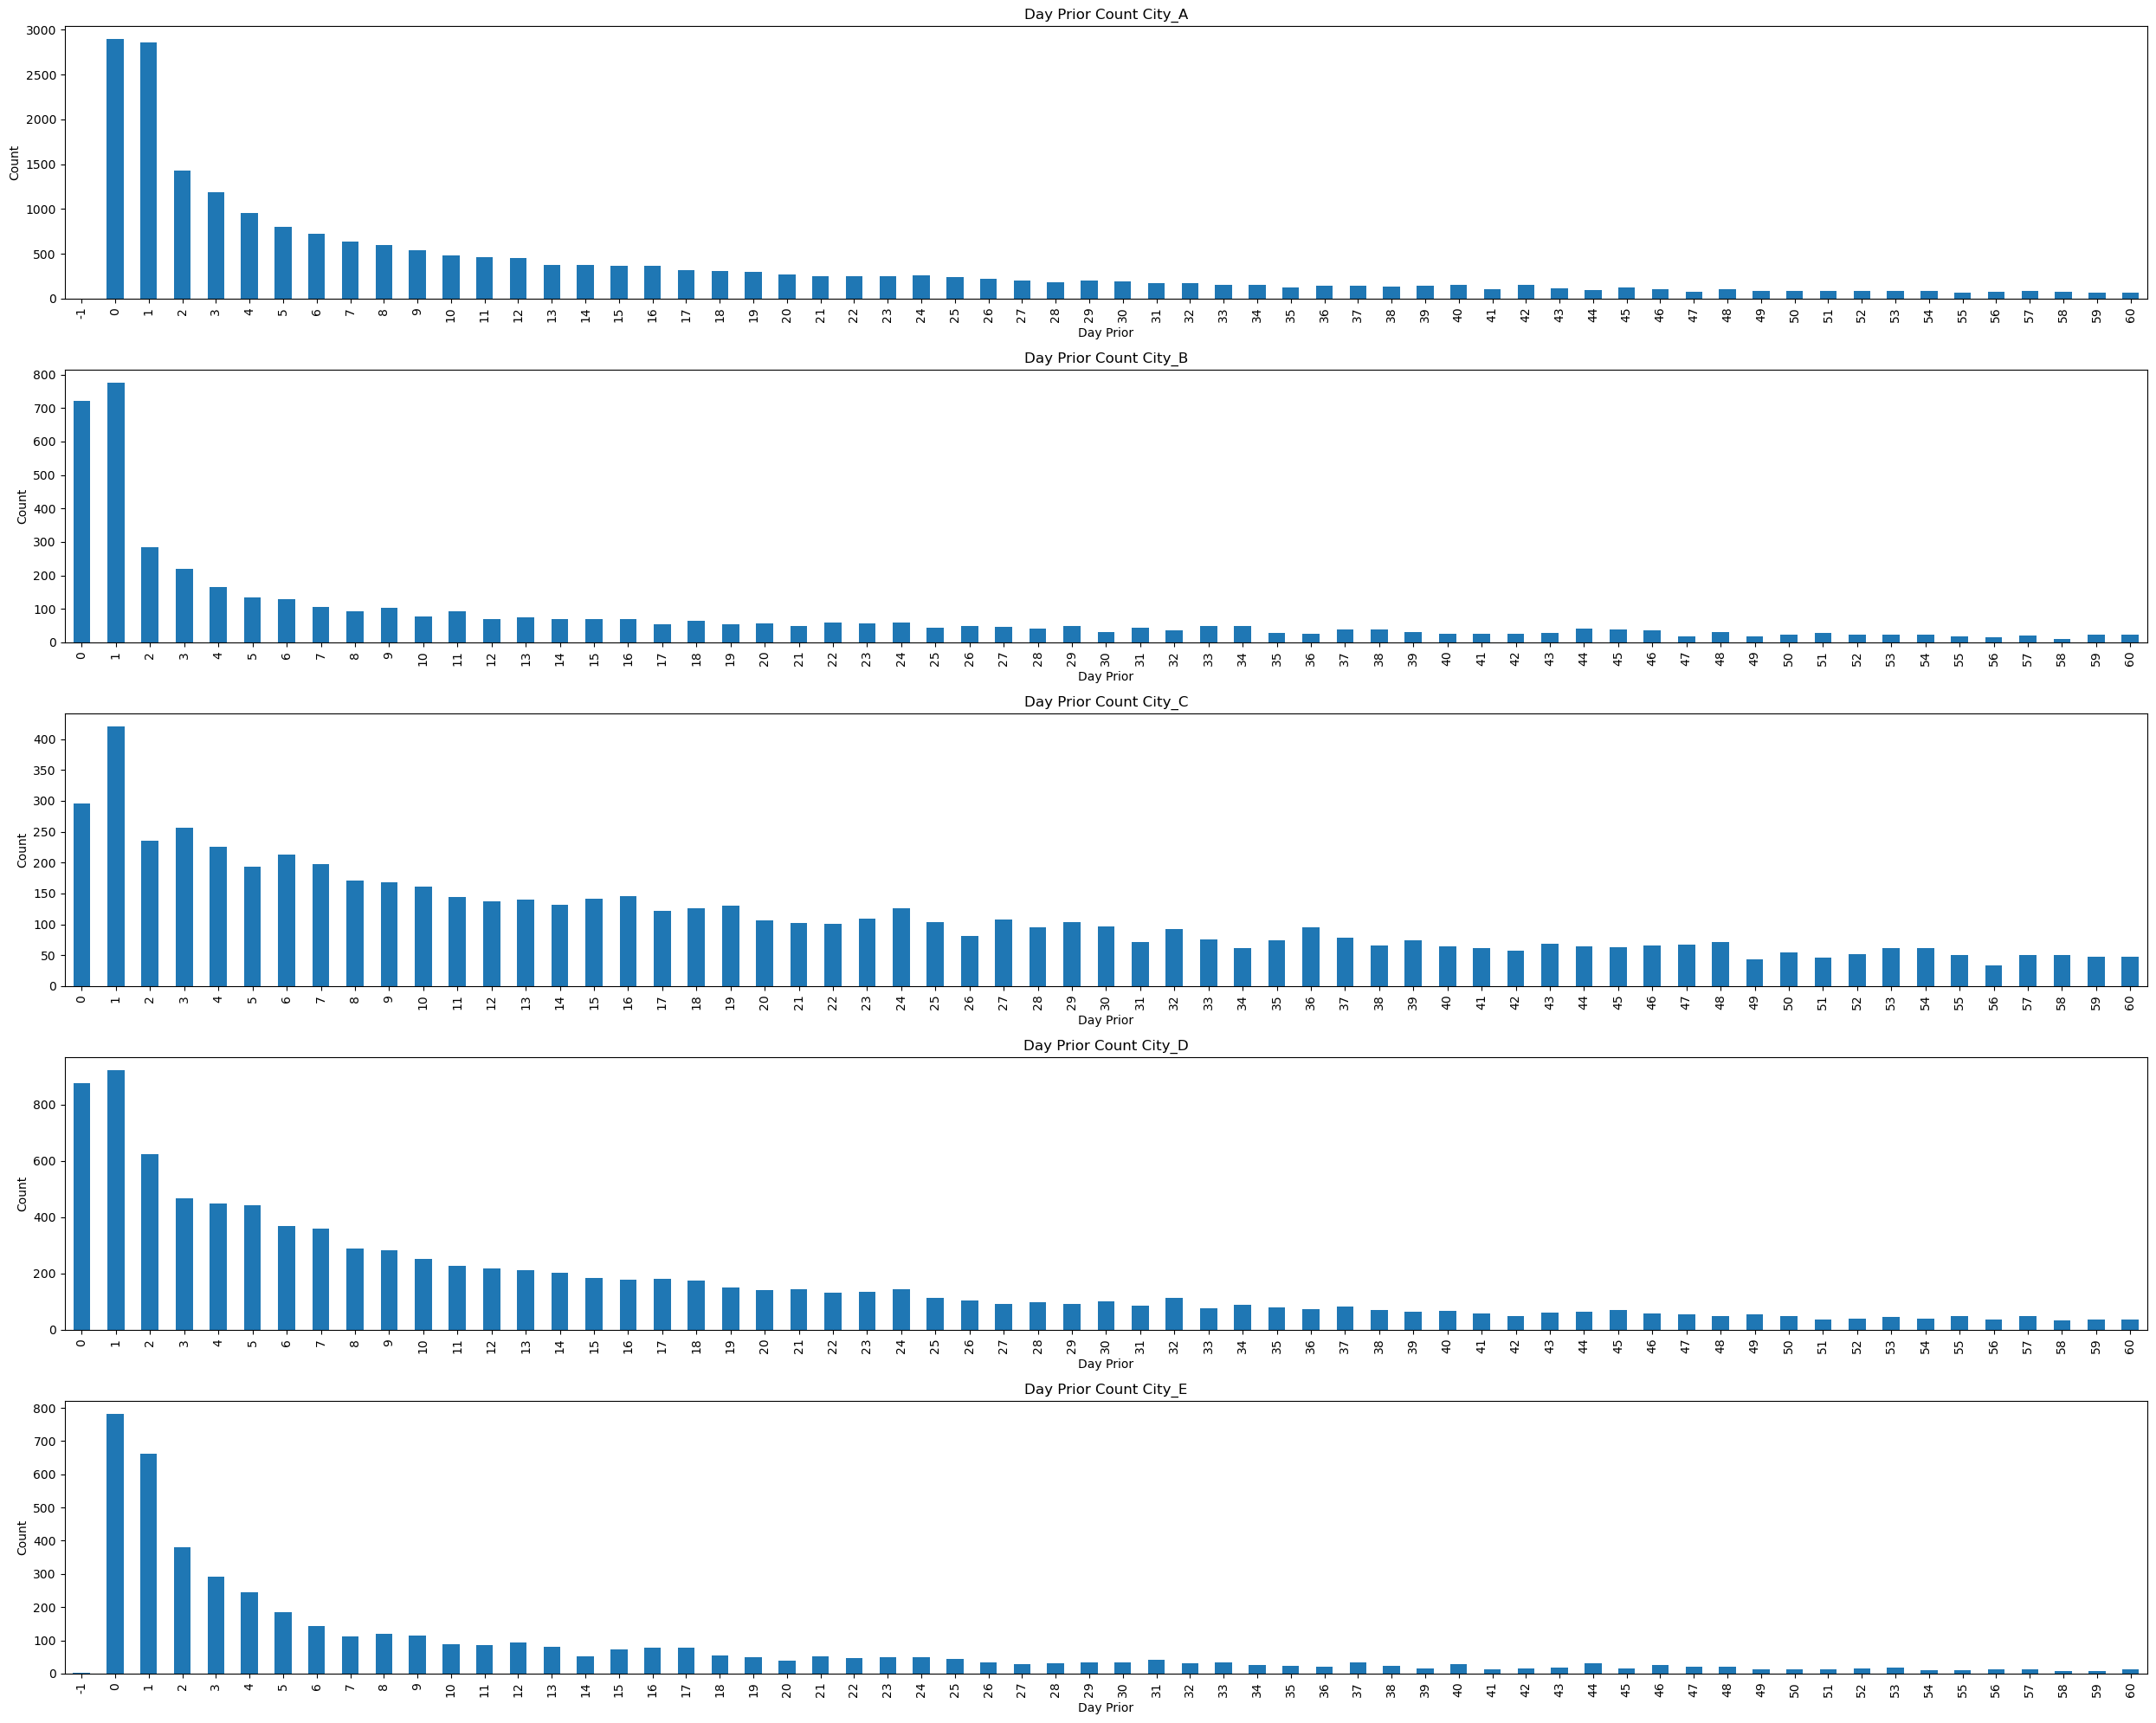

In [7]:
# Create a subplot with 5 rows and 1 col
fig, axes = plt.subplots(5, 1, figsize=(25, 20))

for idx, CITY in enumerate(CITIES):    
    ax = axes[idx]
    
    # Plot 4 : Day Prior Count
    day_prior_counts = hotel_df[hotel_df['City'] == CITY]['days_prior'].value_counts().sort_index()
    day_prior_counts.plot(kind='bar', ax=ax)
    ax.set_title(f'Day Prior Count {CITY}')
    ax.set_xlabel('Day Prior')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

* All 5 cities have similar behaviour where users tend to book hotels only 0 to 1 day prior to their checkin date. 

# 3. Data Visualization <a class="anchor"  id="chapter3"></a>

## 3.1 Checkin Days Frequency <a class="anchor"  id="subchapter3.1"></a>

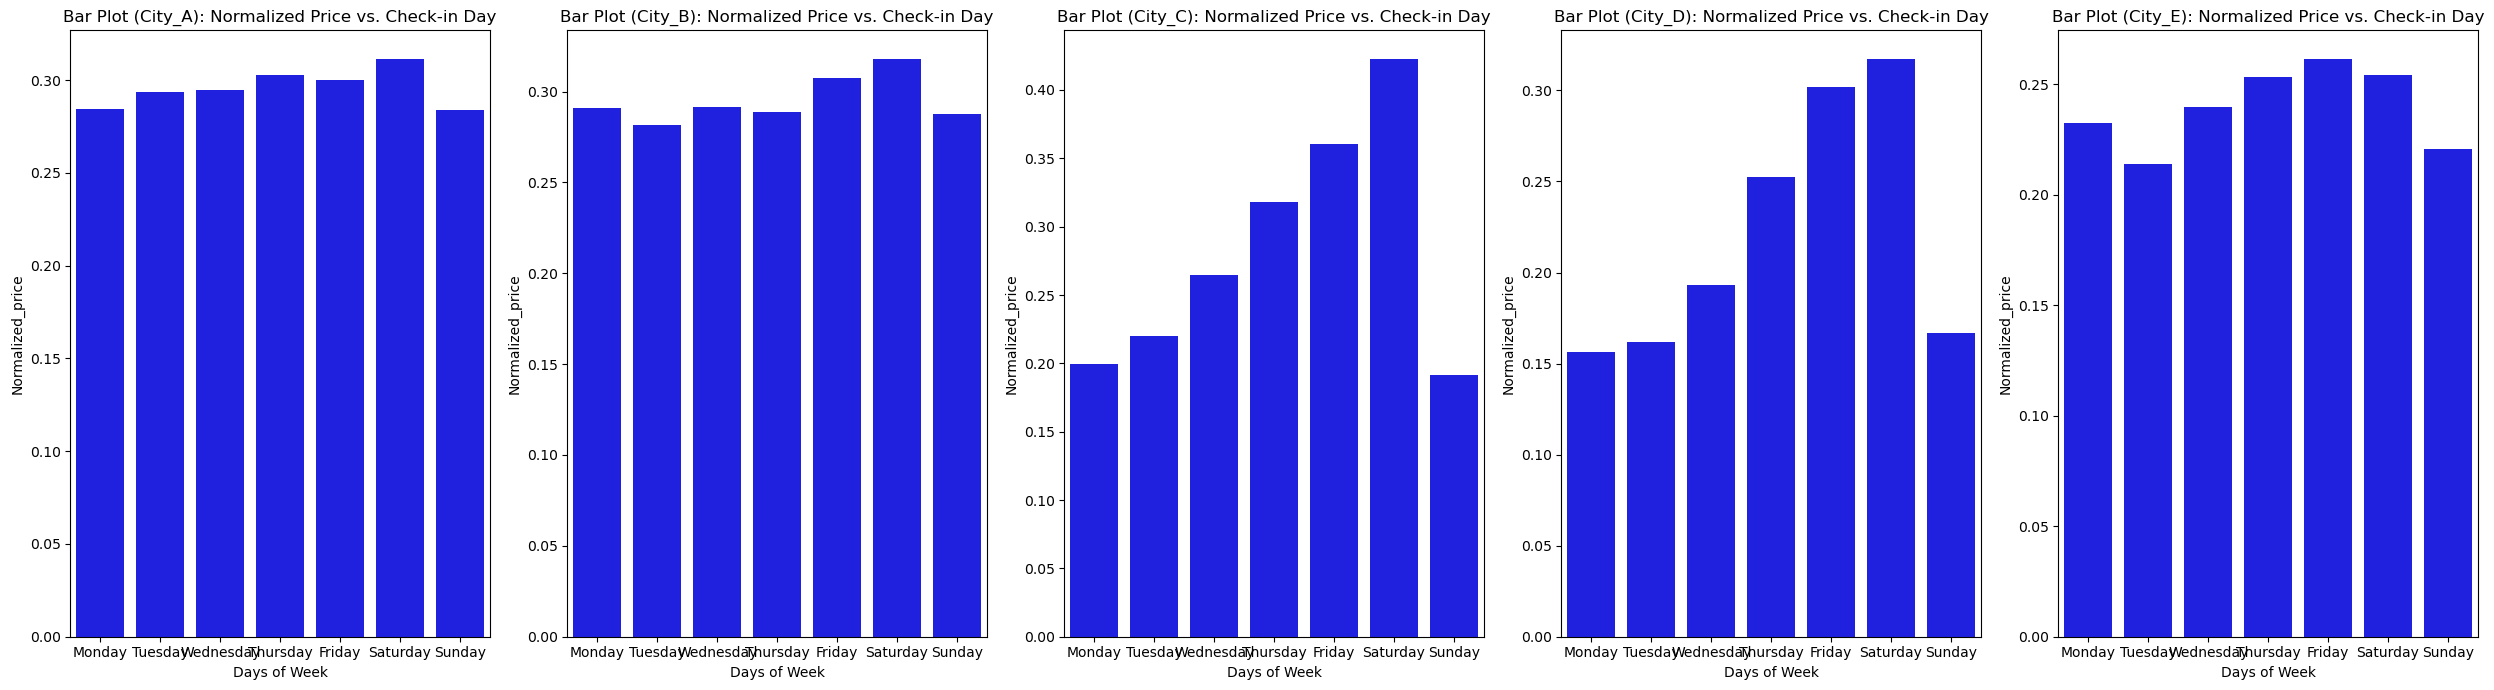

In [8]:
# List of days of the week
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create subplots for each city
fig, axes = plt.subplots(1, 5, figsize=(25, 7))

# Group the data by 'Table Name' and 'checkin_day' and calculate the mean of 'normalized_ADR_USD'
grouped_by_checkin_day = hotel_df.groupby(['City', 'checkin_day'])['normalized_price'].mean().reset_index()

# Loop through each city and plot the box plots
for idx, CITY in enumerate(CITIES):
    # Filter the data for the current city
    grouped_by_checkin_day1 = grouped_by_checkin_day[grouped_by_checkin_day['City'] == CITY]
    grouped_by_checkin_day1 = grouped_by_checkin_day1.set_index('checkin_day').reindex(cats).reset_index()
    
    ax = axes[idx]  # Get the specific subplot for the current city

    # Plot the bar chart using Seaborn
    sns.barplot(data=grouped_by_checkin_day1, x='checkin_day',
                y='normalized_price', ax=ax, color='blue')
    ax.set_xlabel('Days of Week')
    ax.set_ylabel('Normalized_price')
    ax.set_title(f'Bar Plot ({CITY}): Normalized Price vs. Check-in Day')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

* **City A:** Prices for check-ins remain stable throughout the entire week.
* **City B:** Prices for check-ins remain consistent across all days of the week.
* **City C:** Check-in prices have shown a gradual increase from Monday to Saturday, followed by a decrease on Sundays. Notably, the highest check-in prices are observed on Saturdays.
* **City D:** Similar to City C, check-in prices have exhibited a gradual increase from Monday to Saturday, followed by a decline on Sundays. Saturdays tend to have the highest check-in prices.
* **City E:** Prices for check-ins remain uniform and consistent throughout the week across all days.

3.0-Hotel-non-chain-City_B                            16
1.0-Guest House / Bed & Breakfast-non-chain-City_D    14
3.0-Hotel-non-chain-City_A                            11
3.0-Resort-non-chain-City_B                            9
4.0-Resort-non-chain-City_B                            9
                                                      ..
1.5-Capsule Hotel-non-chain-City_C                     1
2.5-Hotel-non-chain-City_C                             1
3.0-Resort-non-chain-City_A                            1
1.0-Hostel-non-chain-City_A                            1
1.0-Serviced Apartment-non-chain-City_E                1
Name: details, Length: 89, dtype: int64

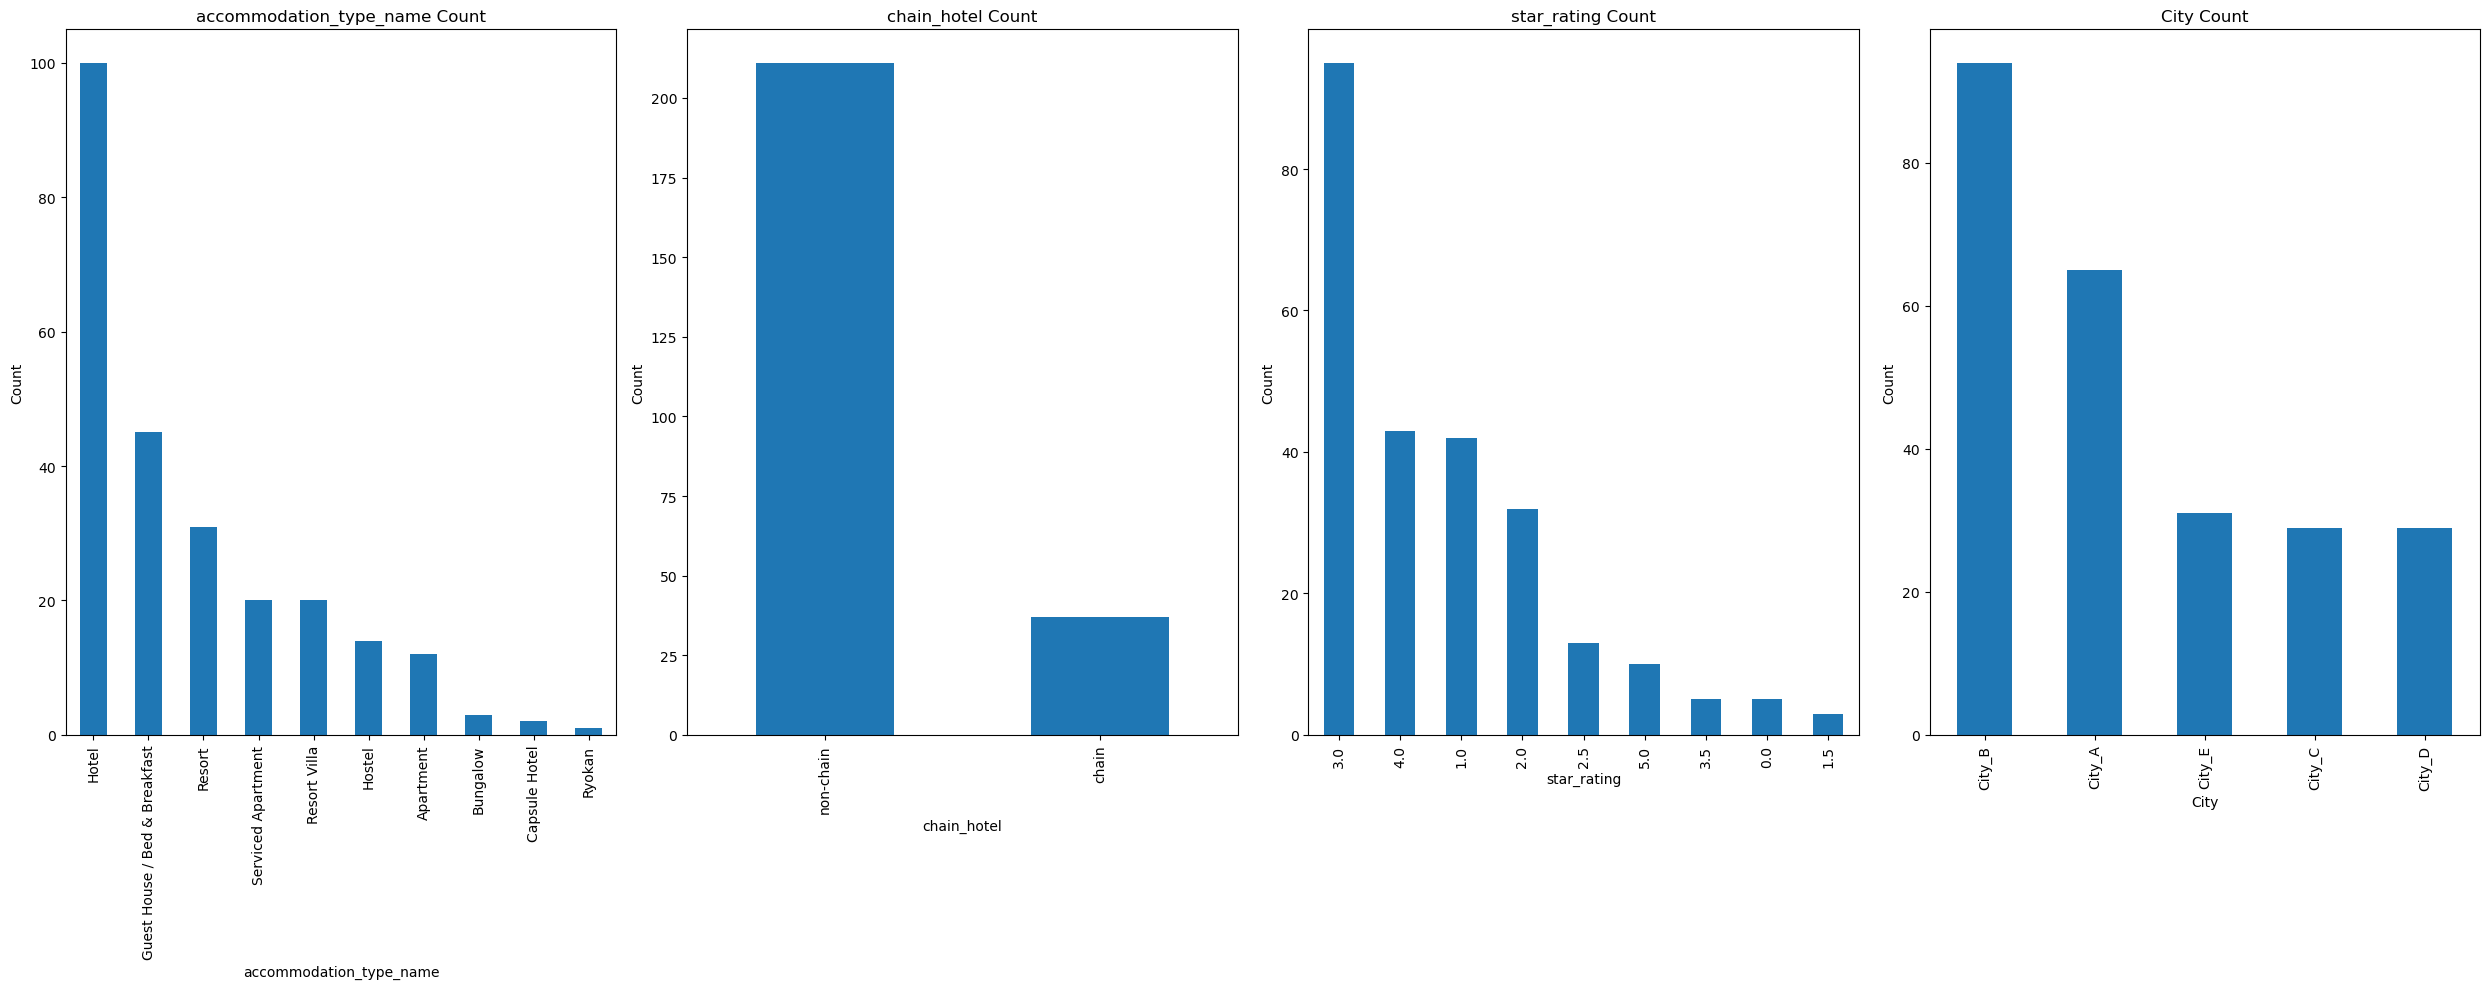

In [9]:
hotel_df['details'] = hotel_df['star_rating'].astype('str') + "-" + hotel_df['accommodation_type_name'] + "-" + hotel_df['chain_hotel'] + "-" + hotel_df['City']
hotel_no_dupe_df = hotel_df.drop_duplicates(subset=['hotel_id'])
increasing_df = hotel_no_dupe_df[hotel_no_dupe_df['price'] == 'increasing']
decreasing_df = hotel_no_dupe_df[hotel_no_dupe_df['price'] == 'decreasing']

# Calculate the count of 'details'
increasing_df_data = increasing_df['details'].value_counts()
increasing_df_data.columns = ['details', 'count']
display(increasing_df_data)

# Creating a subplot with 1 rows and 4 cols
fig, axes = plt.subplots(1, 4, figsize=(25, 10))

for idx, axis in enumerate(['accommodation_type_name', 'chain_hotel', 'star_rating', 'City']):
    ax = axes[idx]  
    axis_count = increasing_df[axis].value_counts()
    axis_count.plot(kind='bar', ax=ax)
    ax.set_title(f'{axis} Count')
    ax.set_xlabel(axis)
    ax.set_ylabel('Count') 
plt.tight_layout()
plt.show()

Above is the details and profile of hotels that have prices increasing when booking day is closer to check in date (lower days prior).

3.0-Hotel-non-chain-City_A                            22
3.0-Resort-non-chain-City_B                           21
4.0-Resort-non-chain-City_B                           17
3.0-Hotel-non-chain-City_B                            16
1.0-Apartment-chain-City_C                            15
                                                      ..
0.0-Guest House / Bed & Breakfast-non-chain-City_B     1
0.0-Hostel-non-chain-City_B                            1
3.0-Hotel-chain-City_B                                 1
3.0-Serviced Apartment-non-chain-City_B                1
2.5-Private Villa-non-chain-City_E                     1
Name: details, Length: 135, dtype: int64

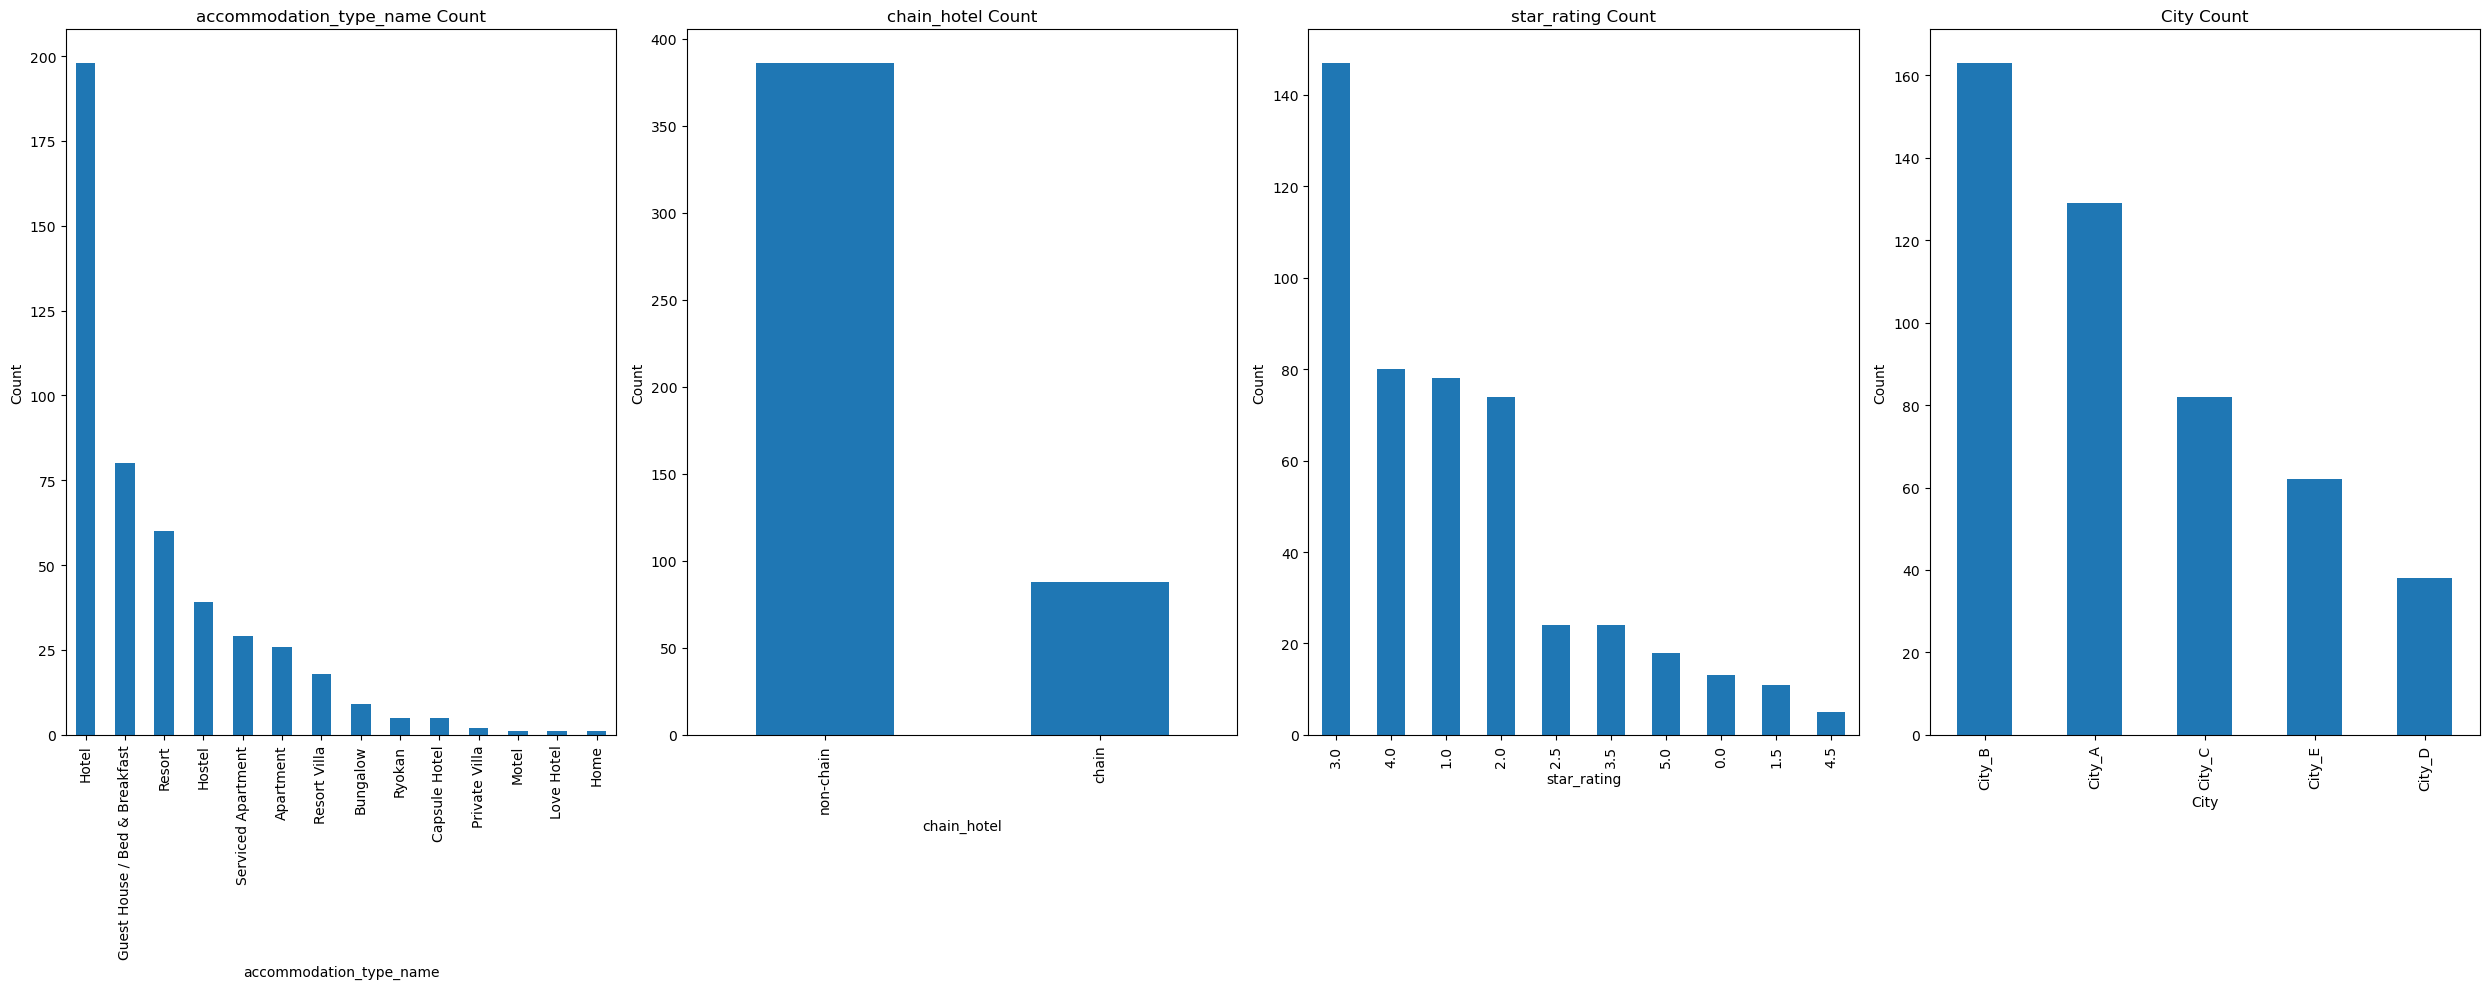

In [10]:
# Calculate the count of 'details'
decreasing_df_data = decreasing_df['details'].value_counts()
decreasing_df_data.columns = ['details', 'count']
display(decreasing_df_data)

# Creating a subplot with 1 rows and 4 cols
fig, axes = plt.subplots(1, 4, figsize=(25, 10))

for idx, axis in enumerate(['accommodation_type_name', 'chain_hotel', 'star_rating', 'City']):
    ax = axes[idx]  
    axis_count = decreasing_df[axis].value_counts()
    axis_count.plot(kind='bar', ax=ax)
    ax.set_title(f'{axis} Count')
    ax.set_xlabel(axis)
    ax.set_ylabel('Count') 
plt.tight_layout()
plt.show()

Above is the details and profile of hotels that have prices increasing when booking day is closer to check in date (lower days prior).

## 3.2 Relationship between Mean Normalized ADR USD and Days Prior <a class="anchor"  id="subchapter3.2"></a>

## 3.3 Correlation Matrix <a class="anchor"  id="subchapter3.3"></a>

In [11]:
# Use pandas get_dummies function to one-hot encode categorical columns
encoded_df = pd.get_dummies(hotel_df, columns=CATEGORICAL_COLS, drop_first=False)
display(encoded_df)

,#,ADR_USD,hotel_id,city_id,star_rating,booking_date,checkin_date,checkout_date,City,days_prior,...,chain_hotel_non-chain,checkin_day_Friday,checkin_day_Monday,checkin_day_Saturday,checkin_day_Sunday,checkin_day_Thursday,checkin_day_Tuesday,checkin_day_Wednesday,price_decreasing,price_increasing
0,1,71.060000,297388,9395,2.5,2016-08-02,2016-10-01,2016-10-02,City_A,60,...,1,0,0,1,0,0,0,0,1,0
1,2,76.560000,298322,9395,3.0,2016-08-02,2016-10-01,2016-10-02,City_A,60,...,1,0,0,1,0,0,0,0,0,1
2,3,153.880000,2313076,9395,5.0,2016-08-02,2016-10-01,2016-10-02,City_A,60,...,0,0,0,1,0,0,0,0,0,1
3,4,126.600000,2240838,9395,3.5,2016-08-04,2016-10-02,2016-10-03,City_A,59,...,1,0,0,0,1,0,0,0,1,0
4,5,115.080000,2240838,9395,3.5,2016-08-04,2016-10-02,2016-10-03,City_A,59,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49059,4813,72.580000,130890,8584,4.0,2016-12-31,2016-12-31,2017-01-02,City_E,0,...,1,0,0,1,0,0,0,0,1,0
49060,4814,70.020000,130890,8584,4.0,2016-12-31,2016-12-31,2017-01-01,City_E,0,...,1,0,0,1,0,0,0,0,1,0
49061,4815,921.260000,21720,8584,5.0,2016-12-31,2016-12-31,2017-01-01,City_E,0,...,1,0,0,1,0,0,0,0,1,0
49062,4816,345.086667,21720,8584,5.0,2016-12-31,2016-12-31,2017-01-03,City_E,0,...,1,0,0,1,0,0,0,0,1,0


booking_day_of_year                      0.147033
checkin_day_Saturday                     0.133374
accommodation_type_name_Capsule Hotel    0.107109
checkin_day_of_year                      0.103931
accommodation_type_name_Hostel           0.072675
checkin_day_Monday                      -0.070776
checkin_day_Sunday                      -0.073986
days_prior                              -0.106505
accommodation_type_name_Hotel           -0.120610
star_rating                             -0.143998
Name: normalized_price, dtype: float64

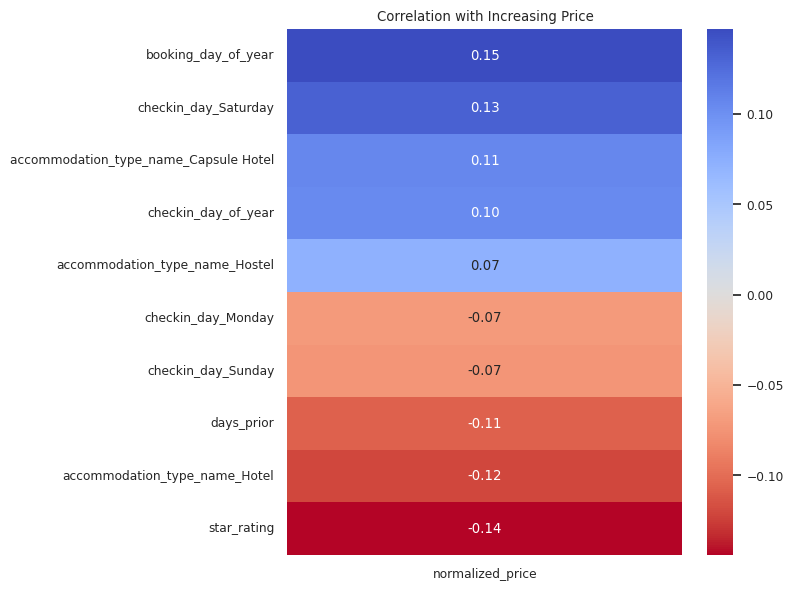

In [12]:
# Drop columns that are not needed for correlation analysis
pre_corr_df = encoded_df.drop(['#', 'ADR_USD', 'hotel_id', 'city_id', 'booking_date', 'checkin_date', 'checkout_date'], axis=1)

increasing_corr_df = pre_corr_df[pre_corr_df['price_increasing'] == 1]
decreasing_corr_df = pre_corr_df[pre_corr_df['price_decreasing'] == 1]

plt.figure(figsize=(8, 6))

# Filter the data for the current city
corr_df = increasing_corr_df.corr().sort_values('normalized_price', ascending=False)

# Extract correlations with the target column and select top and bottom correlated features
target_corr_df = corr_df['normalized_price'].drop(['normalized_price'])
target_corr_df.dropna(inplace=True)
target_corr_df = pd.concat([target_corr_df[:5], target_corr_df[-5:]])
display(target_corr_df)

# Create a heatmap of correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
# sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_df.to_frame(), cmap="coolwarm_r", annot=True, fmt='.2f')


# Adjust layout and display the plots
plt.title(f'Correlation with Increasing Price')
plt.tight_layout()
plt.show()

The correlation coefficients between various features and the "price" variable, ordered by increasing absolute correlation with "price" when sorted in ascending order. Here's how to interpret this correlation matrix when the "price" is increasing:

1. **Positive Correlation**: Positive correlation coefficients (values closer to 1) indicate that as the feature increases, the "price" tends to increase as well. Conversely, as the feature decreases, the "price" tends to decrease.

    * For example, "booking_day_of_year" has a positive correlation of 0.1470 with "price." This suggests that as the booking day of the year increases (possibly indicating bookings made later in the year), the "price" tends to increase. In other words, bookings made later in the year are associated with higher prices.
    * "checkin_day_Saturday" has a positive correlation of 0.1334 with "price." This suggests that bookings for check-in on Saturdays tend to have higher prices compared to other days.
    * "accommodation_type_name_Capsule Hotel" has a positive correlation of 0.1071 with "price." This indicates that bookings for capsule hotels tend to have higher prices.

2. **Negative Correlation**: Negative correlation coefficients (values closer to -1) indicate that as the feature increases, the "price" tends to decrease, and vice versa.

    * For example, "checkin_day_Sunday" has a negative correlation of -0.0740 with "price." This suggests that bookings for check-in on Sundays tend to have lower prices compared to other days.
    * "days_prior" has a negative correlation of -0.1065 with "price." This indicates that as the number of days prior to the booking date increases (possibly indicating bookings made further in advance), the "price" tends to decrease. Booking further in advance is associated with lower prices.
    * "star_rating" has a negative correlation of -0.1440 with "price." This suggests that as the star rating of the accommodation increases, the "price" tends to decrease. Higher-rated accommodations are associated with lower prices.

3. **Interpretation**: Overall, the correlation matrix provides insights into the relationships between these features and the "price" variable when "price" is increasing. Positive correlations indicate that certain features are associated with higher prices, while negative correlations suggest that certain features are associated with lower prices. It's essential to consider these relationships when analyzing pricing trends in the context of your specific application. Additionally, correlation does not imply causation, so further analysis may be needed to understand the underlying factors driving these relationships.

days_prior                               0.174501
chain_hotel_non-chain                    0.084426
checkin_day_Saturday                     0.073280
accommodation_type_name_Motel            0.054513
checkin_day_Friday                       0.051981
accommodation_type_name_Capsule Hotel   -0.056998
checkin_day_Sunday                      -0.060299
accommodation_type_name_Resort          -0.065233
chain_hotel_chain                       -0.084426
star_rating                             -0.132954
Name: normalized_price, dtype: float64

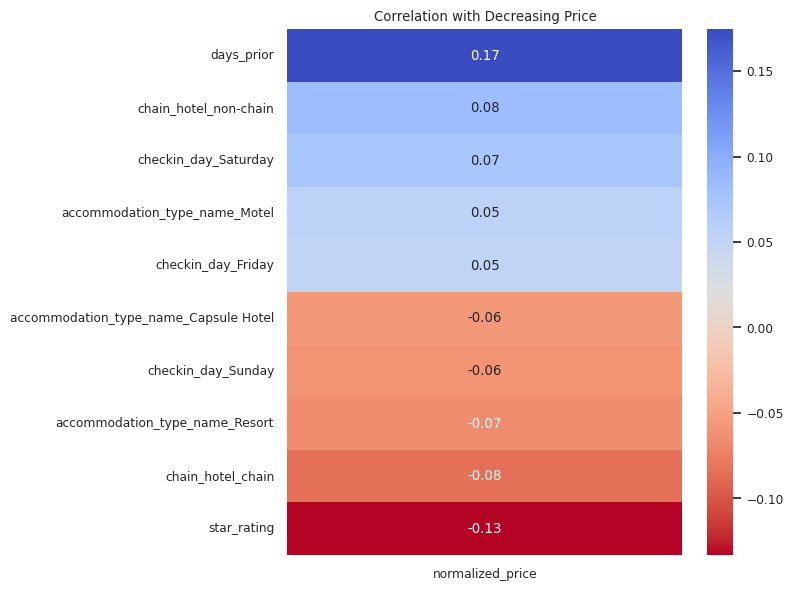

In [13]:
plt.figure(figsize=(8, 6))

# Filter the data for the current city
corr_df = decreasing_corr_df.corr().sort_values('normalized_price', ascending=False)

# Extract correlations with the target column and select top and bottom correlated features
target_corr_df = corr_df['normalized_price'].drop(['normalized_price'])
target_corr_df.dropna(inplace=True)
target_corr_df = pd.concat([target_corr_df[:5], target_corr_df[-5:]])
display(target_corr_df)

# Create a heatmap of correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
# sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_df.to_frame(), cmap="coolwarm_r", annot=True, fmt='.2f')


# Adjust layout and display the plots
plt.title(f'Correlation with Decreasing Price')
plt.tight_layout()
plt.show()

The correlation coefficients between various features and the "price" variable, ordered by decreasing absolute correlation with "price." 

1. **Positive Correlation**: Positive correlation coefficients (values closer to 1) indicate that as the feature increases, the "price" tends to increase as well. Conversely, as the feature decreases, the "price" tends to decrease.
    * For example, "days_prior" has a positive correlation of 0.1745 with "price." This suggests that as the number of days prior to the booking date increases, the "price" tends to increase. In other words, booking further in advance is associated with higher prices.
    * "checkin_day_Saturday" has a positive correlation of 0.0733 with "price." This suggests that bookings for check-in on Saturdays tend to have higher prices compared to other days.
    * "accommodation_type_name_Motel" has a positive correlation of 0.0545 with "price." This indicates that bookings for motels tend to have higher prices.

2. **Negative Correlation**: Negative correlation coefficients (values closer to -1) indicate that as the feature increases, the "price" tends to decrease, and vice versa.
    * For example, "chain_hotel_chain" has a negative correlation of -0.0844 with "price." This suggests that bookings in chain hotels tend to have lower prices compared to non-chain hotels.
    * "star_rating" has a negative correlation of -0.1330 with "price." This indicates that as the star rating of the accommodation increases, the "price" tends to decrease. Higher-rated accommodations are associated with lower prices.
    * "accommodation_type_name_Resort" has a negative correlation of -0.0652 with "price." This suggests that bookings for resorts tend to have lower prices. 
    
3. **Interpretation**: Overall, the correlation matrix provides insights into the relationships between these features and the "price" variable. Positive correlations indicate that certain features are associated with higher prices, while negative correlations suggest that certain features are associated with lower prices. It's essential to consider these relationships when making pricing or booking decisions in the context of your specific application. Additionally, correlation does not imply causation, so further analysis may be needed to understand the underlying factors driving these relationships.

# 4. Numeric Prediction <a class="anchor"  id="chapter4"></a>

## 4.1 Defining Evaluation Metrics <a class="anchor"  id="subchapter4.1"></a>

In [14]:
# Create an empty DataFrame with specified columns
comparison_col = ['Model', 'MSE', 'MAE', 'R2']
comparison_df = pd.DataFrame(columns=comparison_col)
display(comparison_df)

# Function to add model performance metrics to the comparison DataFrame
def add_to_comparison(comparison_df, model_name, mse, mae, r_squared):
    # Create a dictionary with model metrics
    df = {'Model': [model_name], 'MSE': [mse], 'MAE': [mae], 'R2': [r_squared]}
    
    # Concatenate the dictionary as a new row to the comparison DataFrame
    comparison_df = pd.concat([comparison_df, pd.DataFrame(data=df)])
    
    # Return the updated comparison DataFrame
    return comparison_df

,Model,MSE,MAE,R2


Analyzing the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²) involves understanding what each metric represents and interpreting their values in the context of your data and problem. Here's how you can analyze these metrics:

1. **Mean Squared Error (MSE)**:
   - Interpretation: MSE measures the average squared difference between the predicted values and the actual values. A lower MSE indicates better predictive accuracy.
   - Analysis:
     - Compare MSE across models: Compare the MSE values of different models. A model with a lower MSE is generally preferred.
     - Relative scale: Keep in mind that MSE is dependent on the scale of the target variable. A small MSE might be good for a small-scale target variable, but the interpretation may differ for a larger-scale variable.

2. **Mean Absolute Error (MAE)**:
   - Interpretation: MAE measures the average absolute difference between the predicted values and the actual values. It is less sensitive to outliers compared to MSE.
   - Analysis:
     - Interpretability: MAE is easier to interpret as it represents the average error in the original units of the target variable.
     - Outliers: If your data has outliers that disproportionately affect the MSE, MAE might provide a more balanced view of the model's performance.

3. **R-squared (R²)**:
   - Interpretation: R² measures the proportion of the variance in the dependent variable that is explained by the independent variables. It ranges from 0 to 1, where a higher value indicates a better fit.
   - Analysis:
     - Model fit: A higher R² indicates that the model is capturing more of the variability in the data. However, a high R² doesn't necessarily mean that the model is valid; it could be overfitting.
     - Context: R² should be considered in context with the problem and the data. Some data might inherently have lower R² due to noise or external factors.

Additional Analysis Tips:
- Compare with baseline: Compare your model's MSE, MAE, and R² with a baseline model or naive approach to evaluate its improvement.
- Model complexity: Consider the trade-off between model complexity and performance metrics. More complex models might achieve lower training MSE but could overfit.
- Overfitting and underfitting: Analyze the metrics on both training and testing data to identify potential overfitting (low training MSE but high testing MSE) or underfitting (high training and testing MSE).
- Visualize: Plotting the predicted values against the actual values or creating residual plots can provide insights into the model's performance and identify patterns.

In summary, analyzing MSE, MAE, and R² involves interpreting their values, comparing models, considering the context of the problem and data, and using them in conjunction with visual analysis and other evaluation metrics. These metrics provide different perspectives on the model's accuracy, fit, and performance.

In [15]:
# Separate target variable and features
y = encoded_df['normalized_price']  # Target variable (normalized_ADR_USD)
X = encoded_df.drop(['#', 'ADR_USD', 'hotel_id', 'city_id', 'normalized_price', 'booking_day', 'booking_date', 
                     'checkin_date', 'checkout_date', 'City', 'details'], axis=1)  # Features
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Uncomment the following line to print the shapes of the datasets
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

## 4.2 Linear Regression <a class="anchor"  id="subchapter4.2"></a>

Linear regression is a statistical technique that models the relationship between a dependent variable and one or more independent variables using a straight line. It aims to find the best-fitting line that minimizes the difference between observed and predicted values, allowing for predictions and understanding of the relationship between variables.

In [16]:
# Create a Linear Regression model
LR = LinearRegression()

# Train the Linear Regression model
LR.fit(X_train, y_train)

# Predict target variable using the trained model
y_pred = LR.predict(X_test)

# Calculate Mean Square Error (MSE), Mean Absolute Error (MAE), and R-squared
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'LR', mse, mae, r_squared)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,MSE,MAE,R2
0,LR,0.048544,0.171265,0.072939


LR has low MSE and MAE among the models, indicating better accuracy in terms of predicting the target variable. However, the R-squared value is relatively low, suggesting that the model explains only a small portion of the variance in the data.

## 4.3 Decsion Tree <a class="anchor"  id="subchapter4.3"></a>

Decision tree regression is a machine learning technique that uses a tree-like structure to model the relationship between features and a target variable. It breaks down the data into smaller subsets and makes predictions based on the average value of the target variable within each subset, creating a tree of decisions for making predictions.

In [17]:
# Create a Decision Tree Regressor model
DT = DecisionTreeRegressor(random_state=42)

# Fit the model to the training data
DT.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = DT.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'DT', mse, mae, r_squared)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,MSE,MAE,R2
0,LR,0.048544,0.171265,0.072939
0,DT,0.075319,0.191409,-0.438391


DT has high MSE and MAE, indicating poorer predictive accuracy compared to LR. The negative R-squared value suggests that the DT model performs worse than a simple mean prediction.

## 4.4 Lasso Regresion <a class="anchor"  id="subchapter4.4"></a>

Lasso regression is a regression technique that adds a penalty to the absolute values of the coefficients of features, encouraging the model to select only important features and reduce overfitting. It helps in feature selection and regularization, making the model more interpretable and improving its generalization to new data.

The choice of `alpha` controls the strength of regularization. Higher values of `alpha` increase the amount of regularization applied.

In [18]:
# Create a Lasso Regression model
alpha = 0.01  # Regularization parameter
lasso_model = Lasso(alpha=alpha)

# Fit the model to the training data
lasso_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lasso_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Lasso', mse, mae, r_squared)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,MSE,MAE,R2
0,LR,0.048544,0.171265,0.072939
0,DT,0.075319,0.191409,-0.438391
0,Lasso,0.050747,0.177450,0.030864


Lasso regression performs slightly worse than LR in terms of MSE and MAE. The R-squared value is also low, indicating limited explanatory power.

## 4.5 Ridge Regression <a class="anchor"  id="subchapter4.5"></a>

Ridge regression is a regression method that adds a penalty to the squared values of the coefficients of features, encouraging the model to shrink them towards zero. This helps to reduce multicollinearity and overfitting, leading to a more stable and generalizable model.

The choice of `alpha` controls the strength of regularization. Higher values of `alpha` increase the amount of regularization applied.

In [19]:
# Create a Ridge Regression model
alpha = 1.0  # Regularization parameter
ridge_model = Ridge(alpha=alpha)

# Fit the model to the training data
ridge_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = ridge_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Ridge', mse, mae, r_squared)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,MSE,MAE,R2
0,LR,0.048544,0.171265,0.072939
0,DT,0.075319,0.191409,-0.438391
0,Lasso,0.050747,0.177450,0.030864
0,Ridge,0.048515,0.171006,0.073501


Ridge regression's MSE and MAE are similar to LR, but the R-squared value is also low, suggesting a similar level of predictive accuracy.

## 4.6 Elastic Net Regression <a class="anchor"  id="subchapter4.6"></a>

Elastic Net regression is a combination of Lasso and Ridge regressions, adding both L1 (absolute value) and L2 (squared value) penalties to the coefficients of features. It strikes a balance between feature selection and regularization, addressing the limitations of individual methods and providing a more flexible approach to regression modeling.

In [20]:
# Create an Elastic Net Regression model
alpha = 0.01  # Regularization parameter
l1_ratio = 0.5  # Mixing parameter between L1 and L2 regularization
elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

# Fit the model to the training data
elastic_net_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = elastic_net_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Elastic Net', mse, mae, r_squared)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,MSE,MAE,R2
0,LR,0.048544,0.171265,0.072939
0,DT,0.075319,0.191409,-0.438391
0,Lasso,0.050747,0.177450,0.030864
0,Ridge,0.048515,0.171006,0.073501
0,Elastic Net,0.050368,0.176629,0.038112


Elastic Net regression's performance is similar to Lasso regression, with slightly higher MSE and MAE and a low R-squared value.

In this case, Linear Regression (LR) appears to be the best model based on the lowest MSE and MAE, indicating better predictive accuracy. However, it's important to note that the R-squared values for all models are relatively low, suggesting that the models may not explain a significant portion of the variance in the target variable. Depending on the context of your problem, you might consider exploring more complex models or feature engineering to improve model performance. Additionally, consider the interpretability and computational requirements of the models for your specific use case.

# 5. Categorical Predictions

## 5.1 Defining Evaluation Metrics <a class="anchor"  id="subchapter5.1"></a>

In [21]:
# Create an empty DataFrame with specified columns
comparison_col = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC']
comparison_df = pd.DataFrame(columns=comparison_col)
display(comparison_df)

# Function to add model performance metrics to the comparison DataFrame
def add_to_comparison(comparison_df, model_name, accuracy, precision, recall, f1, roc_auc):
    # Create a dictionary with model metrics
    df = {'Model': [model_name], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1], 'ROC': [roc_auc]}
    
    # Concatenate the dictionary as a new row to the comparison DataFrame
    comparison_df = pd.concat([comparison_df, pd.DataFrame(data=df)])
    
    # Return the updated comparison DataFrame
    return comparison_df

,Model,Accuracy,Precision,Recall,F1,ROC


1. **Precision Score:**
    * Precision measures the accuracy of positive predictions made by a model.
    * It is calculated as the ratio of true positive (TP) predictions to the total positive predictions, i.e., TP / (TP + false positives).
    * Precision is useful when minimizing false positives is important. For example, in a spam email classifier, high precision means fewer legitimate emails are classified as spam.
    
2. **Recall Score:**
    * Recall, also known as sensitivity or true positive rate, measures the ability of a model to identify all relevant instances in the dataset.
    * It is calculated as the ratio of true positive (TP) predictions to the total actual positives, i.e., TP / (TP + false negatives).
    * Recall is important when you want to minimize false negatives. For example, in medical diagnosis, high recall ensures that serious conditions are not missed.

3. **Accuracy Score:**
    * Accuracy is a measure of overall model correctness.
    * It is calculated as the ratio of correct predictions (true positives and true negatives) to the total number of predictions, i.e., (TP + TN) / (TP + TN + FP + FN).
    * While accuracy is a commonly used metric, it may not be suitable for imbalanced datasets where one class dominates.

4. **F1 Score:**
    * The F1 score is the harmonic mean of precision and recall.
    * It balances precision and recall and is particularly useful when there is an uneven class distribution or when false positives and false negatives have different costs.
    * It is calculated as 2 * (precision * recall) / (precision + recall).

5. **ROC AUC (Receiver Operating Characteristic Area Under the Curve):**
    * ROC AUC is used for binary classification problems and evaluates the model's ability to distinguish between the positive and negative classes.
    * It plots the true positive rate (recall) against the false positive rate at various thresholds and calculates the area under the ROC curve.
    * An AUC of 0.5 indicates a random classifier, while an AUC of 1.0 indicates a perfect classifier.
    * ROC AUC is a valuable metric when you want to assess the model's performance across different threshold settings.

In summary, precision and recall focus on the performance of a classifier on one class, while accuracy considers both classes. F1 score provides a balance between precision and recall, and ROC AUC assesses a classifier's ability to distinguish between classes at various threshold levels. The choice of which metric to use depends on the specific goals and characteristics of your classification problem.

In [22]:
y = encoded_df[['price_increasing', 'price_decreasing']].idxmax(axis=1).str.split('_').str[1]
y = y.replace({'increasing' : 1, 'decreasing' : 0})
X = encoded_df.drop(['#', 'ADR_USD', 'hotel_id', 'city_id', 'normalized_price', 'booking_day', 'booking_date', 
                     'checkin_date', 'checkout_date', 'City', 'details', 'price_increasing', 'price_decreasing'], axis=1)  # Features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## 5.2 Logistic Regression <a class="anchor"  id="subchapter5.2"></a>

In [23]:
# Logistic Regression
logistic_regression = LogisticRegression()  # Initialize a Logistic Regression classifier
logistic_regression.fit(X_train, y_train)  # Fit the classifier on the training data
y_pred = logistic_regression.predict(X_test)  # Make predictions on the testing data

# Calculate various classification metrics
accuracy = accuracy_score(y_test, y_pred)  # Accuracy
precision = precision_score(y_test, y_pred)  # Precision
recall = recall_score(y_test, y_pred)  # Recall
f1 = f1_score(y_test, y_pred)  # F1-score
roc_auc = roc_auc_score(y_test, logistic_regression.predict_proba(X_test)[:, 1])  # ROC AUC
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion Matrix

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Logistic Regression', accuracy, precision, recall, f1, roc_auc)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,Accuracy,Precision,Recall,F1,ROC
0,Logistic Regression,0.755215,0.269504,0.016316,0.030769,0.672968


The logistic regression model has a relatively high accuracy, but its precision and recall are quite low, indicating that it might not perform well at correctly identifying positive cases.


## 5.3 Decision Tree Classifier <a class="anchor"  id="subchapter5.3"></a>

In [24]:
# Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier(
    max_depth=3  # Maximum depth of the decision tree
)
decision_tree_classifier.fit(X_train, y_train)  # Fit the Decision Tree classifier on the training data
y_pred = decision_tree_classifier.predict(X_test)  # Make predictions on the testing data

# Calculate various classification metrics
accuracy = accuracy_score(y_test, y_pred)  # Accuracy
precision = precision_score(y_test, y_pred)  # Precision
recall = recall_score(y_test, y_pred)  # Recall
f1 = f1_score(y_test, y_pred)  # F1-score
roc_auc = roc_auc_score(y_test, decision_tree_classifier.predict_proba(X_test)[:, 1])  # ROC AUC
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion Matrix

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Decision Tree Classifier', accuracy, precision, recall, f1, roc_auc)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,Accuracy,Precision,Recall,F1,ROC
0,Logistic Regression,0.755215,0.269504,0.016316,0.030769,0.672968
0,Decision Tree Classifier,0.765337,0.527869,0.138257,0.219122,0.705250


The decision tree classifier has a good balance between accuracy and precision, making it a reasonable choice. However, the recall is relatively low.

## 5.4 Random Forest Classifier <a class="anchor"  id="subchapter5.4"></a>

In [25]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,         # Number of decision trees in the random forest
    random_state=42           # Random seed for reproducibility
)
rf_classifier.fit(X_train, y_train)  # Fit the Random Forest classifier on the training data
y_pred = rf_classifier.predict(X_test)  # Make predictions on the testing data

# Calculate various classification metrics
accuracy = accuracy_score(y_test, y_pred)  # Accuracy
precision = precision_score(y_test, y_pred)  # Precision
recall = recall_score(y_test, y_pred)  # Recall
f1 = f1_score(y_test, y_pred)  # F1-score
roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:,1])  # ROC AUC
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion Matrix

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Random Forest Classifier', accuracy, precision, recall, f1, roc_auc)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,Accuracy,Precision,Recall,F1,ROC
0,Logistic Regression,0.755215,0.269504,0.016316,0.030769,0.672968
0,Decision Tree Classifier,0.765337,0.527869,0.138257,0.219122,0.705250
0,Random Forest Classifier,0.761043,0.497826,0.393302,0.439434,0.736774


The random forest classifier performs well in terms of recall and F1 score. It provides a good trade-off between precision and recall.

## 5.5 Naive Bayes Classifier <a class="anchor"  id="subchapter5.5"></a>

In [26]:
# Naive Bayes Classifier
nb_classifier = GaussianNB()  # Initialize a Gaussian Naive Bayes classifier
nb_classifier.fit(X_train, y_train)  # Fit the classifier on the training data
y_pred = nb_classifier.predict(X_test)  # Make predictions on the testing data

# Calculate various classification metrics
accuracy = accuracy_score(y_test, y_pred)  # Accuracy
precision = precision_score(y_test, y_pred)  # Precision
recall = recall_score(y_test, y_pred)  # Recall
f1 = f1_score(y_test, y_pred)  # F1-score
roc_auc = roc_auc_score(y_test, nb_classifier.predict_proba(X_test)[:,1])  # ROC AUC
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion Matrix

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Gaussian NB', accuracy, precision, recall, f1, roc_auc)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,Accuracy,Precision,Recall,F1,ROC
0,Logistic Regression,0.755215,0.269504,0.016316,0.030769,0.672968
0,Decision Tree Classifier,0.765337,0.527869,0.138257,0.219122,0.705250
0,Random Forest Classifier,0.761043,0.497826,0.393302,0.439434,0.736774
0,Gaussian NB,0.340900,0.256477,0.930872,0.402152,0.649323


The Gaussian Naive Bayes model has a high recall but very low precision, which may result in many false positives.

## 5.6 K-Nearest Neighbors <a class="anchor"  id="subchapter5.6"></a>

In [27]:
# k-Nearest Neighbors (k-NN) Classifier
knn_classifier = KNeighborsClassifier(
    n_neighbors=3  # Number of neighbors to consider (k)
)
knn_classifier.fit(X_train, y_train)  # Fit the k-NN classifier on the training data
y_pred = knn_classifier.predict(X_test)  # Make predictions on the testing data

# Calculate various classification metrics
accuracy = accuracy_score(y_test, y_pred)  # Accuracy
precision = precision_score(y_test, y_pred)  # Precision
recall = recall_score(y_test, y_pred)  # Recall
f1 = f1_score(y_test, y_pred)  # F1-score
roc_auc = roc_auc_score(y_test, knn_classifier.predict_proba(X_test)[:, 1])  # ROC AUC
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion Matrix

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'K Neighbours Classifier', accuracy, precision, recall, f1, roc_auc)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,Accuracy,Precision,Recall,F1,ROC
0,Logistic Regression,0.755215,0.269504,0.016316,0.030769,0.672968
0,Decision Tree Classifier,0.765337,0.527869,0.138257,0.219122,0.705250
0,Random Forest Classifier,0.761043,0.497826,0.393302,0.439434,0.736774
0,Gaussian NB,0.340900,0.256477,0.930872,0.402152,0.649323
0,K Neighbours Classifier,0.719734,0.376499,0.269644,0.314236,0.599350


The K Neighbors Classifier provides a moderate balance between accuracy, precision, and recall.

## 5.7 Gradient Boosting Classifier <a class="anchor"  id="subchapter5.7"></a>

In [28]:
# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(
    n_estimators=100,         # Number of boosting stages (trees) to combine
    learning_rate=0.1,        # Learning rate for adjusting the contribution of each tree
    random_state=42           # Random seed for reproducibility
)
gb_classifier.fit(X_train, y_train)  # Fit the Gradient Boosting classifier on the training data
y_pred = gb_classifier.predict(X_test)  # Make predictions on the testing data

# Calculate various classification metrics
accuracy = accuracy_score(y_test, y_pred)  # Accuracy
precision = precision_score(y_test, y_pred)  # Precision
recall = recall_score(y_test, y_pred)  # Recall
f1 = f1_score(y_test, y_pred)  # F1-score
roc_auc = roc_auc_score(y_test, gb_classifier.predict_proba(X_test)[:, 1])  # ROC AUC
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion Matrix

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Gradient Boosting Classifier', accuracy, precision, recall, f1, roc_auc)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,Accuracy,Precision,Recall,F1,ROC
0,Logistic Regression,0.755215,0.269504,0.016316,0.030769,0.672968
0,Decision Tree Classifier,0.765337,0.527869,0.138257,0.219122,0.705250
0,Random Forest Classifier,0.761043,0.497826,0.393302,0.439434,0.736774
0,Gaussian NB,0.340900,0.256477,0.930872,0.402152,0.649323
0,K Neighbours Classifier,0.719734,0.376499,0.269644,0.314236,0.599350
0,Gradient Boosting Classifier,0.775869,0.597997,0.179476,0.276090,0.770959


This model has a good accuracy and precision but relatively low recall. It might be suitable if precision is crucial.

## 5.8 AdaBoosting Classifier <a class="anchor"  id="subchapter5.8"></a>

In [29]:
# AdaBoost Classifier (Boosting)
adaboost_classifier = AdaBoostClassifier(
    n_estimators=100,        # Number of weak learners (Decision Trees) to combine
    learning_rate=0.1,       # Learning rate for adjusting the contribution of each weak learner
    random_state=42          # Random seed for reproducibility
)
adaboost_classifier.fit(X_train, y_train)  # Fit the AdaBoost classifier on the training data
y_pred = adaboost_classifier.predict(X_test)  # Make predictions on the testing data

# Calculate various classification metrics
accuracy = accuracy_score(y_test, y_pred)  # Accuracy
precision = precision_score(y_test, y_pred)  # Precision
recall = recall_score(y_test, y_pred)  # Recall
f1 = f1_score(y_test, y_pred)  # F1-score
roc_auc = roc_auc_score(y_test, adaboost_classifier.predict_proba(X_test)[:, 1])  # ROC AUC
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion Matrix

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Adaboost Classifier', accuracy, precision, recall, f1, roc_auc)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,Accuracy,Precision,Recall,F1,ROC
0,Logistic Regression,0.755215,0.269504,0.016316,0.030769,0.672968
0,Decision Tree Classifier,0.765337,0.527869,0.138257,0.219122,0.705250
0,Random Forest Classifier,0.761043,0.497826,0.393302,0.439434,0.736774
0,Gaussian NB,0.340900,0.256477,0.930872,0.402152,0.649323
0,K Neighbours Classifier,0.719734,0.376499,0.269644,0.314236,0.599350
0,Gradient Boosting Classifier,0.775869,0.597997,0.179476,0.276090,0.770959
0,Adaboost Classifier,0.764008,0.516640,0.139974,0.220270,0.708719


Adaboost provides a reasonable trade-off between accuracy and precision.

## 5.9 Neural Network<a class="anchor"  id="subchapter5.9"></a>

In [30]:
# Standardize features (for neural networks)
scaler = StandardScaler()  # Initialize a StandardScaler object for feature scaling
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test_scaled = scaler.transform(X_test)  # Transform the testing data using the same scaling parameters

# Neural Network (Multi-layer Perceptron)
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(50, 30),  # Specify the architecture of the neural network (50 neurons in the first hidden layer, 30 in the second)
    max_iter=1000,  # Maximum number of iterations for training
    random_state=42  # Random seed for reproducibility
)
mlp_classifier.fit(X_train_scaled, y_train)  # Train the neural network on the scaled training data
y_pred = mlp_classifier.predict(X_test_scaled)  # Make predictions on the scaled testing data

# Calculate various classification metrics
accuracy = accuracy_score(y_test, y_pred)  # Accuracy
precision = precision_score(y_test, y_pred)  # Precision
recall = recall_score(y_test, y_pred)  # Recall
f1 = f1_score(y_test, y_pred)  # F1-score
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test)[:, 1])  # ROC AUC
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion Matrix

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Neural Network', accuracy, precision, recall, f1, roc_auc)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,Accuracy,Precision,Recall,F1,ROC
0,Logistic Regression,0.755215,0.269504,0.016316,0.030769,0.672968
0,Decision Tree Classifier,0.765337,0.527869,0.138257,0.219122,0.705250
0,Random Forest Classifier,0.761043,0.497826,0.393302,0.439434,0.736774
0,Gaussian NB,0.340900,0.256477,0.930872,0.402152,0.649323
0,K Neighbours Classifier,0.719734,0.376499,0.269644,0.314236,0.599350
0,Gradient Boosting Classifier,0.775869,0.597997,0.179476,0.276090,0.770959
0,Adaboost Classifier,0.764008,0.516640,0.139974,0.220270,0.708719
0,Neural Network,0.776074,0.566380,0.254616,0.351303,0.500000


The neural network has good accuracy and precision but relatively low recall. The ROC AUC of 0.5 suggests that it's not performing better than random guessing, which may indicate an issue with the model.

In summary, the "best" model depends on your specific use case and the trade-off between precision and recall that you are willing to make. If high precision is crucial (minimizing false positives), you might consider models like the Gradient Boosting Classifier or Random Forest. If high recall is important (minimizing false negatives), you might explore other models or fine-tune the existing ones to improve recall. Additionally, consider the interpretability and computational complexity of the models for your application.